# Active Template Model - Basics
This notebook provides a basic tutorial on Active Template Models (ATMs). ATMs are used to perform image alignment driven by a statistical shape model.

## 1. Loading shapes

The first step in building our ATM will be to import all the annotations of the training set of LFPW database. Luckily, `Menpo`'s `io` module allows us to do exactly that using only a few lines of code:

In [1]:
path_to_lfpw = '/vol/atlas/databases/lfpw/'

In [2]:
import menpo.io as mio

training_shapes = []
# load landmarked images
for i in mio.import_landmark_files(path_to_lfpw + 'trainset/*.pts', verbose=True):
    training_shapes.append(i['all'])

Importing assets: [==========] 100% (811/811) - 00:00:00 remaining


:0: FutureWarning: IPython widgets are experimental and may change in the future.


The previous cell loads all the PTS files of the LFPW.

The `Menpo` ecosystem is well equiped with a series of predefined IPython Notebook widgets for the most common data visualization tasks. In order to check if the data has been correctly imported we will use the ``visualize_pointclouds`` widget.

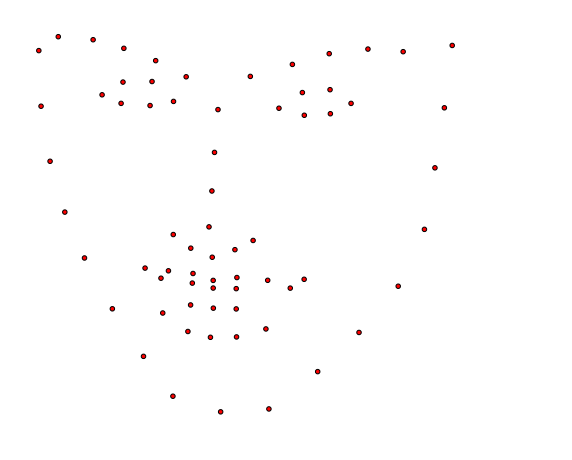

In [3]:
%matplotlib inline
from menpo.visualize import visualize_pointclouds

visualize_pointclouds(training_shapes)

## 2. Building a simple ATM

In order to build an ATM, we need to load a template image. This will be the first image of the LFPW training set.

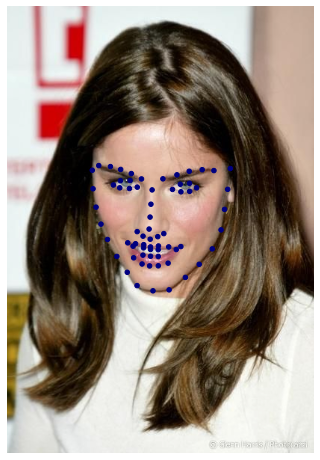

In [4]:
template_image = mio.import_image(path_to_lfpw + 'trainset/image_0001.png')
template_image.view_landmarks();

It is very easy to build the ATM

In [5]:
from menpofit.atm import ATMBuilder

# build ATM
atm = ATMBuilder(normalization_diagonal=150).build(training_shapes, template_image, verbose=True)

- Building model for each of the 3 pyramid levels
  - Level 1: Done
  - Level 2: Done
  - Level 3: Done


As first class citizens of `Menpo`, AAMs can be printed just like any other `Menpo` object (e.g. `Images` or `PointClouds)`:

In [6]:
print(atm)

Active Template Model
 - 811 training shapes.
 - DifferentiablePiecewiseAffine Warp.
 - Gaussian pyramid with 3 levels and downscale factor of 2.
   - Each level has a scaled shape model (reference frame).
   - Pyramid was applied on feature space.
   - Feature is igo with 6 channels per image.
   - Level 1 (no downscale): 
     - Reference frame of length 136764 (22794 x 6C, 176W x 174H x 6C)
     - 133 shape components (100.00% of variance)
   - Level 2 (downscale by 2): 
     - Reference frame of length 34128 (5688 x 6C, 91W x 90H x 6C)
     - 133 shape components (100.00% of variance)
   - Level 3 (downscale by 4): 
     - Reference frame of length 8520 (1420 x 6C, 49W x 48H x 6C)
     - 133 shape components (100.00% of variance)



We can also visualize the ATM model

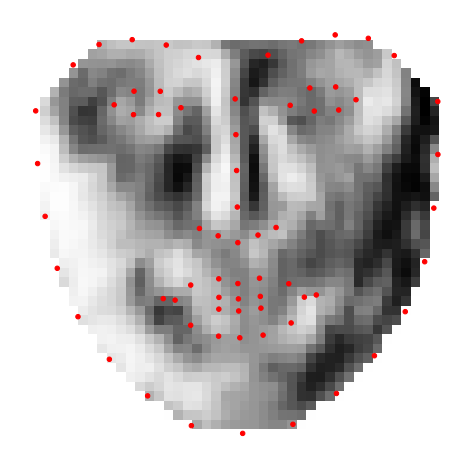

In [7]:
atm.view_atm_widget()

## 3. Fit a simple ATM 

In ``menpofit``, ATMs can be fitted to images by creating `Fitter` objects around them. 

One of the most popular and well known family of algorithms for fitting ATMs is the one based around the original `Lucas-Kanade` algorithm for Image Alignment. In order to fit our AAM using an algorithms of the previous family, `Menpo` allows the user to define a `LucasKanadeATMFitter` object. Again, using a single line of code!!!

In [8]:
from menpofit.atm import LucasKanadeATMFitter

# define Lucas-Kanade based ATM fitter
fitter = LucasKanadeATMFitter(atm, n_shape=[3, 6, 12])

The previous cell has created a `LucasKanadeATMFitter` that will fit images using 3, 6 and 12 shape compenents per level.

It is also important to know that these `LucasKanadeATMFitter` objects are also first class citizen in `Menpo` and, consequently, can be printed:

In [9]:
print(fitter)

Active Template Model Fitter
 - Lucas-Kanade Image-IC
 - Transform is OrthoMDTransform and residual is SSD.
 - 811 training images.
 - Gaussian pyramid with 3 levels and downscale factor of 2.
   - Each level has a scaled shape model (reference frame).
   - Pyramid was applied on feature space.
   - Feature is igo with 6 channels per image.
   - Level 1 (no downscale): 
     - Reference frame of length 136764 (22794 x 6C, 176W x 174H x 6C)
     - 16 motion components

   - Level 2 (downscale by 2): 
     - Reference frame of length 34128 (5688 x 6C, 91W x 90H x 6C)
     - 10 motion components

   - Level 3 (downscale by 4): 
     - Reference frame of length 8520 (1420 x 6C, 49W x 48H x 6C)
     - 7 motion components




Fitting a `LucasKanadeATMFitter` to an image is as simple as calling its `fit` method. Let's try it by fitting the second image of the LFPW trainset!!!

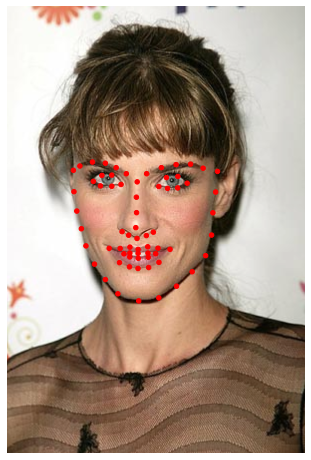

In [10]:
test_image = mio.import_image(path_to_lfpw + 'trainset/image_0002.png')
test_image.view_widget()

In [14]:
# obtain groubnd truth (original) landmarks
gt_s = test_image.landmarks['PTS'].lms

# generate initialization landmarks
initial_s = fitter.perturb_shape(gt_s, noise_std=0.07)

# fit image
fitting_result = fitter.fit(test_image, initial_s, gt_shape=gt_s)

# print fitting error
print(fitting_result)

Fitting Result
 - Initial error: 0.1100
 - Final error: 0.0183
 - LK-ATM-Image-IC method with 3 pyramid levels, 50 iterations and using igo features.


Let's visualize the result using the widget

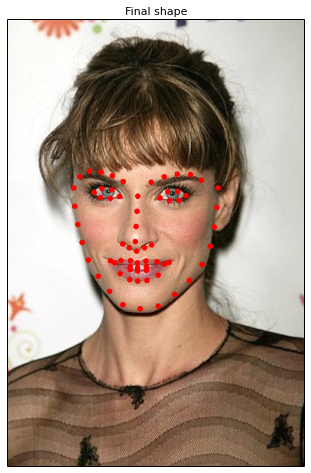

In [15]:
fitting_result.view_widget()